## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [4]:
# ! pip install torchinfo

In [309]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data

import torchinfo

from IPython.display import clear_output

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import numpy as np

import os

from tqdm import tqdm

In [310]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [311]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [312]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [313]:
d_train, d_val = data.random_split(fmnist_dataset_train, [0.85, 0.15])

In [277]:
train_loader = data.DataLoader(d_train, batch_size=128, shuffle=True)
val_loader = data.DataLoader(d_val, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test, batch_size=256, shuffle=False)

In [278]:
len(fmnist_dataset_train), len(fmnist_dataset_test)

(60000, 10000)

In [279]:
len(d_train), len(d_val)

(51000, 9000)

In [280]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


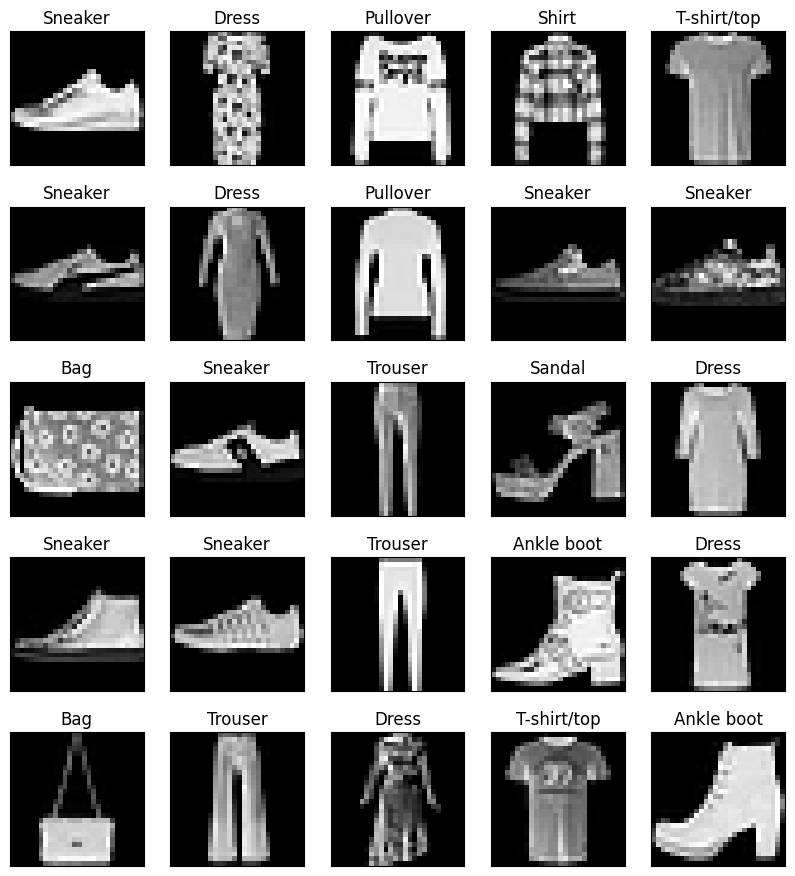

In [281]:
number = 25
plt.figure(figsize=(10, 11))
n = 0
for i in range(1, number + 1):
    plt.subplot(number // 5, 5, i)
    plt.imshow(img[n][0], cmap="gray")
    plt.title(fmnist_dataset_train.classes[label[n]])
    plt.xticks([])
    plt.yticks([])
    n += 1

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [282]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [283]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

num_epochs = 20

In [284]:
torchinfo.summary(model, (1, 28, 28, 1))

Layer (type:depth-idx)                   Output Shape              Param #
TinyNeuralNetwork                        [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 128]                  100,480
│    └─ReLU: 2-3                         [1, 128]                  --
│    └─Linear: 2-4                       [1, 10]                   1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.41
Estimated Total Size (MB): 0.41

Your experiments come here:

In [285]:
def train_nn(*, model, epochs, train_data, optimizer, train_data_val=None):
    loss_lst = []
    loss_lst_val = []
    
    for _e in range(epochs):
        model.train()
        
        loss_mean = 0
        lm_count = 0
    
        correct = 0
        total = 0
    
        train_tqdm = tqdm(train_data, leave=True)
        for x_train, y_train in train_tqdm:
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            
            predict = model(x_train)
            loss = loss_func(predict, y_train)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            lm_count += 1
            loss_mean = 1 / lm_count * loss.item() + (1 - 1 / lm_count) * loss_mean
    
            predicted = torch.argmax(predict, dim=1)
            correct += (predicted == y_train).sum().item()
            total += y_train.size(0)
            accuracy = correct / total
            
            train_tqdm.set_description(f"Epoch [{_e+1}/{epochs}], loss_mean={loss_mean:.3f}, acc={accuracy:.3f}")
        
        
        if train_data_val:
            model.eval()
            Q_val = 0
            count_val = 0

            correct_val = 0
            total_val = 0

            with torch.no_grad():
                for x_val, y_val in train_data_val:
                    x_val = x_val.to(device)
                    y_val = y_val.to(device)
                    
                    p = model(x_val)
                    loss = loss_func(p, y_val)
                    Q_val += loss.item()
                    count_val += 1

                    predicted_val = torch.argmax(p, dim=1)
                    correct_val += (predicted_val == y_val).sum().item()
                    total_val += y_val.size(0)
        
            Q_val /= count_val
            accuracy_val = correct_val / total_val
        
            loss_lst.append(loss_mean)
            loss_lst_val.append(Q_val)
        
            print(f" | Train_loss={loss_mean:.3f}, Train_accuracy={accuracy:.3f}, Val_loss={Q_val:.3f}, Val_accuracy={accuracy_val:.3f}")
    
    return loss_lst, loss_lst_val

In [286]:
loss_lst, loss_lst_val = train_nn(model=model,
                                  epochs=num_epochs, 
                                  train_data=train_loader, 
                                  optimizer=opt,
                                  train_data_val=val_loader)

Epoch [1/20], loss_mean=0.616, acc=0.793: 100%|██████████████████████████████████████| 399/399 [00:12<00:00, 32.93it/s]


 | Train_loss=0.616, Train_accuracy=0.793, Val_loss=0.474, Val_accuracy=0.835


Epoch [2/20], loss_mean=0.435, acc=0.848: 100%|██████████████████████████████████████| 399/399 [00:12<00:00, 32.65it/s]


 | Train_loss=0.435, Train_accuracy=0.848, Val_loss=0.423, Val_accuracy=0.853


Epoch [3/20], loss_mean=0.398, acc=0.861: 100%|██████████████████████████████████████| 399/399 [00:12<00:00, 33.13it/s]


 | Train_loss=0.398, Train_accuracy=0.861, Val_loss=0.392, Val_accuracy=0.865


Epoch [4/20], loss_mean=0.371, acc=0.868: 100%|██████████████████████████████████████| 399/399 [00:12<00:00, 33.15it/s]


 | Train_loss=0.371, Train_accuracy=0.868, Val_loss=0.374, Val_accuracy=0.871


Epoch [5/20], loss_mean=0.352, acc=0.874: 100%|██████████████████████████████████████| 399/399 [00:12<00:00, 32.87it/s]


 | Train_loss=0.352, Train_accuracy=0.874, Val_loss=0.358, Val_accuracy=0.875


Epoch [6/20], loss_mean=0.338, acc=0.879: 100%|██████████████████████████████████████| 399/399 [00:12<00:00, 32.69it/s]


 | Train_loss=0.338, Train_accuracy=0.879, Val_loss=0.365, Val_accuracy=0.870


Epoch [7/20], loss_mean=0.322, acc=0.885: 100%|██████████████████████████████████████| 399/399 [00:11<00:00, 33.96it/s]


 | Train_loss=0.322, Train_accuracy=0.885, Val_loss=0.357, Val_accuracy=0.872


Epoch [8/20], loss_mean=0.309, acc=0.888: 100%|██████████████████████████████████████| 399/399 [00:11<00:00, 34.31it/s]


 | Train_loss=0.309, Train_accuracy=0.888, Val_loss=0.334, Val_accuracy=0.885


Epoch [9/20], loss_mean=0.299, acc=0.892: 100%|██████████████████████████████████████| 399/399 [00:11<00:00, 35.33it/s]


 | Train_loss=0.299, Train_accuracy=0.892, Val_loss=0.324, Val_accuracy=0.888


Epoch [10/20], loss_mean=0.289, acc=0.895: 100%|█████████████████████████████████████| 399/399 [00:11<00:00, 35.37it/s]


 | Train_loss=0.289, Train_accuracy=0.895, Val_loss=0.325, Val_accuracy=0.886


Epoch [11/20], loss_mean=0.278, acc=0.899: 100%|█████████████████████████████████████| 399/399 [00:11<00:00, 34.08it/s]


 | Train_loss=0.278, Train_accuracy=0.899, Val_loss=0.321, Val_accuracy=0.882


Epoch [12/20], loss_mean=0.275, acc=0.899: 100%|█████████████████████████████████████| 399/399 [00:11<00:00, 34.21it/s]


 | Train_loss=0.275, Train_accuracy=0.899, Val_loss=0.316, Val_accuracy=0.891


Epoch [13/20], loss_mean=0.264, acc=0.904: 100%|█████████████████████████████████████| 399/399 [00:11<00:00, 34.57it/s]


 | Train_loss=0.264, Train_accuracy=0.904, Val_loss=0.332, Val_accuracy=0.883


Epoch [14/20], loss_mean=0.257, acc=0.906: 100%|█████████████████████████████████████| 399/399 [00:11<00:00, 34.96it/s]


 | Train_loss=0.257, Train_accuracy=0.906, Val_loss=0.312, Val_accuracy=0.890


Epoch [15/20], loss_mean=0.252, acc=0.908: 100%|█████████████████████████████████████| 399/399 [00:11<00:00, 34.51it/s]


 | Train_loss=0.252, Train_accuracy=0.908, Val_loss=0.321, Val_accuracy=0.889


Epoch [16/20], loss_mean=0.242, acc=0.912: 100%|█████████████████████████████████████| 399/399 [00:11<00:00, 33.58it/s]


 | Train_loss=0.242, Train_accuracy=0.912, Val_loss=0.322, Val_accuracy=0.890


Epoch [17/20], loss_mean=0.238, acc=0.912: 100%|█████████████████████████████████████| 399/399 [00:11<00:00, 34.23it/s]


 | Train_loss=0.238, Train_accuracy=0.912, Val_loss=0.329, Val_accuracy=0.886


Epoch [18/20], loss_mean=0.231, acc=0.915: 100%|█████████████████████████████████████| 399/399 [00:11<00:00, 34.22it/s]


 | Train_loss=0.231, Train_accuracy=0.915, Val_loss=0.322, Val_accuracy=0.888


Epoch [19/20], loss_mean=0.227, acc=0.917: 100%|█████████████████████████████████████| 399/399 [00:11<00:00, 34.97it/s]


 | Train_loss=0.227, Train_accuracy=0.917, Val_loss=0.323, Val_accuracy=0.887


Epoch [20/20], loss_mean=0.221, acc=0.919: 100%|█████████████████████████████████████| 399/399 [00:11<00:00, 34.15it/s]


 | Train_loss=0.221, Train_accuracy=0.919, Val_loss=0.307, Val_accuracy=0.896


In [287]:
def test_model(test_data, model):
    model.eval()
    
    Q = 0
    
    for x_test, y_test in tqdm(test_data):
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        
        with torch.no_grad():
            p = model(x_test)
            p = torch.argmax(p, dim=1)
            Q += torch.sum(p == y_test).item()
    
    Q /= len(fmnist_dataset_test)
    print(f"Accuracy: {Q:.3f}")

In [288]:
test_model(test_loader, model)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 23.09it/s]

Accuracy: 0.887


In [289]:
def plot_loss(loss_lst, loss_lst_val, num_epochs, ticks=True):
    plt.figure(figsize=(7, 4))
    plt.plot(range(1, num_epochs + 1), loss_lst, label="train")
    plt.plot(range(1, num_epochs + 1), loss_lst_val, label="validation")
    plt.title("Loss: train vs validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    if ticks:
        plt.xticks(range(1, num_epochs + 1))
        plt.yticks(np.arange(0.1, 0.9, 0.1))
    plt.legend()
    plt.grid()
    plt.show()

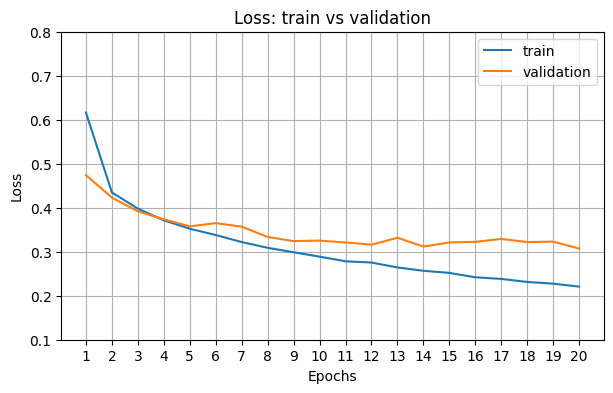

In [290]:
plot_loss(loss_lst, loss_lst_val, num_epochs)

Без свёрточных слоев модель начинает переобучаться и почти не обучается после 12 эпох.

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [291]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [292]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

num_epochs = 20

In [293]:
torchinfo.summary(model, (1, 28, 28, 1))

Layer (type:depth-idx)                   Output Shape              Param #
OverfittingNeuralNetwork                 [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Flatten: 2-1                      [1, 784]                  --
│    └─Linear: 2-2                       [1, 1024]                 803,840
│    └─ReLU: 2-3                         [1, 1024]                 --
│    └─Linear: 2-4                       [1, 512]                  524,800
│    └─ReLU: 2-5                         [1, 512]                  --
│    └─Linear: 2-6                       [1, 128]                  65,664
│    └─ReLU: 2-7                         [1, 128]                  --
│    └─Linear: 2-8                       [1, 10]                   1,290
Total params: 1,395,594
Trainable params: 1,395,594
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.40
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 5.58
Estimated

In [294]:
loss_lst, loss_lst_val = train_nn(model=model,
                                  epochs=num_epochs, 
                                  train_data=train_loader, 
                                  optimizer=opt,
                                  train_data_val=val_loader)

Epoch [1/20], loss_mean=0.548, acc=0.798: 100%|██████████████████████████████████████| 399/399 [00:12<00:00, 33.12it/s]


 | Train_loss=0.548, Train_accuracy=0.798, Val_loss=0.423, Val_accuracy=0.852


Epoch [2/20], loss_mean=0.373, acc=0.862: 100%|██████████████████████████████████████| 399/399 [00:11<00:00, 33.45it/s]


 | Train_loss=0.373, Train_accuracy=0.862, Val_loss=0.395, Val_accuracy=0.854


Epoch [3/20], loss_mean=0.337, acc=0.876: 100%|██████████████████████████████████████| 399/399 [00:12<00:00, 32.11it/s]


 | Train_loss=0.337, Train_accuracy=0.876, Val_loss=0.346, Val_accuracy=0.877


Epoch [4/20], loss_mean=0.311, acc=0.885: 100%|██████████████████████████████████████| 399/399 [00:12<00:00, 31.67it/s]


 | Train_loss=0.311, Train_accuracy=0.885, Val_loss=0.317, Val_accuracy=0.885


Epoch [5/20], loss_mean=0.289, acc=0.891: 100%|██████████████████████████████████████| 399/399 [00:12<00:00, 33.18it/s]


 | Train_loss=0.289, Train_accuracy=0.891, Val_loss=0.312, Val_accuracy=0.888


Epoch [6/20], loss_mean=0.277, acc=0.896: 100%|██████████████████████████████████████| 399/399 [00:12<00:00, 32.71it/s]


 | Train_loss=0.277, Train_accuracy=0.896, Val_loss=0.312, Val_accuracy=0.889


Epoch [7/20], loss_mean=0.261, acc=0.902: 100%|██████████████████████████████████████| 399/399 [00:12<00:00, 32.33it/s]


 | Train_loss=0.261, Train_accuracy=0.902, Val_loss=0.297, Val_accuracy=0.893


Epoch [8/20], loss_mean=0.246, acc=0.905: 100%|██████████████████████████████████████| 399/399 [00:12<00:00, 32.26it/s]


 | Train_loss=0.246, Train_accuracy=0.905, Val_loss=0.317, Val_accuracy=0.895


Epoch [9/20], loss_mean=0.237, acc=0.911: 100%|██████████████████████████████████████| 399/399 [00:12<00:00, 32.78it/s]


 | Train_loss=0.237, Train_accuracy=0.911, Val_loss=0.327, Val_accuracy=0.883


Epoch [10/20], loss_mean=0.227, acc=0.914: 100%|█████████████████████████████████████| 399/399 [00:12<00:00, 32.59it/s]


 | Train_loss=0.227, Train_accuracy=0.914, Val_loss=0.311, Val_accuracy=0.896


Epoch [11/20], loss_mean=0.214, acc=0.917: 100%|█████████████████████████████████████| 399/399 [00:12<00:00, 32.56it/s]


 | Train_loss=0.214, Train_accuracy=0.917, Val_loss=0.308, Val_accuracy=0.899


Epoch [12/20], loss_mean=0.207, acc=0.921: 100%|█████████████████████████████████████| 399/399 [00:12<00:00, 32.67it/s]


 | Train_loss=0.207, Train_accuracy=0.921, Val_loss=0.312, Val_accuracy=0.902


Epoch [13/20], loss_mean=0.197, acc=0.925: 100%|█████████████████████████████████████| 399/399 [00:12<00:00, 32.41it/s]


 | Train_loss=0.197, Train_accuracy=0.925, Val_loss=0.308, Val_accuracy=0.899


Epoch [14/20], loss_mean=0.191, acc=0.927: 100%|█████████████████████████████████████| 399/399 [00:12<00:00, 32.29it/s]


 | Train_loss=0.191, Train_accuracy=0.927, Val_loss=0.311, Val_accuracy=0.900


Epoch [15/20], loss_mean=0.184, acc=0.929: 100%|█████████████████████████████████████| 399/399 [00:12<00:00, 32.12it/s]


 | Train_loss=0.184, Train_accuracy=0.929, Val_loss=0.305, Val_accuracy=0.905


Epoch [16/20], loss_mean=0.176, acc=0.932: 100%|█████████████████████████████████████| 399/399 [00:12<00:00, 32.13it/s]


 | Train_loss=0.176, Train_accuracy=0.932, Val_loss=0.374, Val_accuracy=0.890


Epoch [17/20], loss_mean=0.169, acc=0.934: 100%|█████████████████████████████████████| 399/399 [00:12<00:00, 31.97it/s]


 | Train_loss=0.169, Train_accuracy=0.934, Val_loss=0.324, Val_accuracy=0.903


Epoch [18/20], loss_mean=0.161, acc=0.937: 100%|█████████████████████████████████████| 399/399 [00:12<00:00, 31.83it/s]


 | Train_loss=0.161, Train_accuracy=0.937, Val_loss=0.332, Val_accuracy=0.906


Epoch [19/20], loss_mean=0.155, acc=0.939: 100%|█████████████████████████████████████| 399/399 [00:12<00:00, 31.64it/s]


 | Train_loss=0.155, Train_accuracy=0.939, Val_loss=0.349, Val_accuracy=0.895


Epoch [20/20], loss_mean=0.152, acc=0.940: 100%|█████████████████████████████████████| 399/399 [00:12<00:00, 31.06it/s]


 | Train_loss=0.152, Train_accuracy=0.940, Val_loss=0.358, Val_accuracy=0.899


In [295]:
test_model(test_loader, model)

100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.68it/s]

Accuracy: 0.890


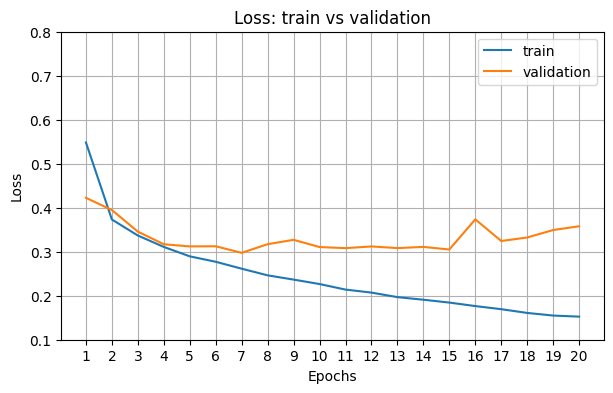

In [296]:
plot_loss(loss_lst, loss_lst_val, num_epochs)

Epoch [1/20], loss_mean=1.081, acc=0.605: 100%|████████████████████████████████████████| 47/47 [00:01<00:00, 30.08it/s]


 | Train_loss=1.081, Train_accuracy=0.605, Val_loss=0.684, Val_accuracy=0.732


Epoch [2/20], loss_mean=0.590, acc=0.786: 100%|████████████████████████████████████████| 47/47 [00:01<00:00, 33.62it/s]


 | Train_loss=0.590, Train_accuracy=0.786, Val_loss=0.555, Val_accuracy=0.792


Epoch [3/20], loss_mean=0.518, acc=0.810: 100%|████████████████████████████████████████| 47/47 [00:01<00:00, 32.80it/s]


 | Train_loss=0.518, Train_accuracy=0.810, Val_loss=0.565, Val_accuracy=0.792


Epoch [4/20], loss_mean=0.462, acc=0.834: 100%|████████████████████████████████████████| 47/47 [00:01<00:00, 32.40it/s]


 | Train_loss=0.462, Train_accuracy=0.834, Val_loss=0.474, Val_accuracy=0.821


Epoch [5/20], loss_mean=0.395, acc=0.855: 100%|████████████████████████████████████████| 47/47 [00:01<00:00, 32.98it/s]


 | Train_loss=0.395, Train_accuracy=0.855, Val_loss=0.491, Val_accuracy=0.812


Epoch [6/20], loss_mean=0.372, acc=0.861: 100%|████████████████████████████████████████| 47/47 [00:01<00:00, 33.36it/s]


 | Train_loss=0.372, Train_accuracy=0.861, Val_loss=0.463, Val_accuracy=0.825


Epoch [7/20], loss_mean=0.339, acc=0.872: 100%|████████████████████████████████████████| 47/47 [00:01<00:00, 32.44it/s]


 | Train_loss=0.339, Train_accuracy=0.872, Val_loss=0.458, Val_accuracy=0.838


Epoch [8/20], loss_mean=0.315, acc=0.881: 100%|████████████████████████████████████████| 47/47 [00:01<00:00, 34.45it/s]


 | Train_loss=0.315, Train_accuracy=0.881, Val_loss=0.444, Val_accuracy=0.843


Epoch [9/20], loss_mean=0.305, acc=0.886: 100%|████████████████████████████████████████| 47/47 [00:01<00:00, 32.50it/s]


 | Train_loss=0.305, Train_accuracy=0.886, Val_loss=0.463, Val_accuracy=0.835


Epoch [10/20], loss_mean=0.311, acc=0.884: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 35.17it/s]


 | Train_loss=0.311, Train_accuracy=0.884, Val_loss=0.432, Val_accuracy=0.849


Epoch [11/20], loss_mean=0.279, acc=0.898: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 35.72it/s]


 | Train_loss=0.279, Train_accuracy=0.898, Val_loss=0.429, Val_accuracy=0.848


Epoch [12/20], loss_mean=0.264, acc=0.903: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 33.00it/s]


 | Train_loss=0.264, Train_accuracy=0.903, Val_loss=0.450, Val_accuracy=0.842


Epoch [13/20], loss_mean=0.236, acc=0.912: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 33.00it/s]


 | Train_loss=0.236, Train_accuracy=0.912, Val_loss=0.470, Val_accuracy=0.846


Epoch [14/20], loss_mean=0.238, acc=0.909: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.25it/s]


 | Train_loss=0.238, Train_accuracy=0.909, Val_loss=0.455, Val_accuracy=0.849


Epoch [15/20], loss_mean=0.212, acc=0.921: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 33.39it/s]


 | Train_loss=0.212, Train_accuracy=0.921, Val_loss=0.457, Val_accuracy=0.854


Epoch [16/20], loss_mean=0.200, acc=0.927: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 33.35it/s]


 | Train_loss=0.200, Train_accuracy=0.927, Val_loss=0.507, Val_accuracy=0.837


Epoch [17/20], loss_mean=0.208, acc=0.921: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 33.27it/s]


 | Train_loss=0.208, Train_accuracy=0.921, Val_loss=0.452, Val_accuracy=0.860


Epoch [18/20], loss_mean=0.180, acc=0.931: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 31.69it/s]


 | Train_loss=0.180, Train_accuracy=0.931, Val_loss=0.489, Val_accuracy=0.850


Epoch [19/20], loss_mean=0.186, acc=0.932: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 30.84it/s]


 | Train_loss=0.186, Train_accuracy=0.932, Val_loss=0.466, Val_accuracy=0.856


Epoch [20/20], loss_mean=0.175, acc=0.933: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 31.99it/s]


 | Train_loss=0.175, Train_accuracy=0.933, Val_loss=0.555, Val_accuracy=0.848


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 21.25it/s]


Accuracy: 0.848


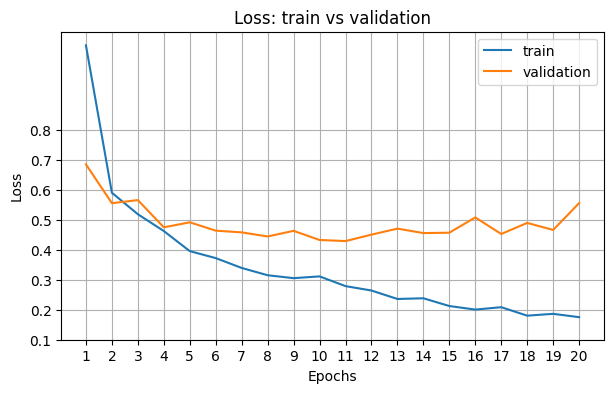

In [297]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

num_epochs = 20

d_train_1, d_val_1, _ = data.random_split(fmnist_dataset_train, [0.1, 0.1, 0.8])

train_loader_1 = data.DataLoader(d_train_1, batch_size=128, shuffle=True)
val_loader_1 = data.DataLoader(d_val_1, batch_size=128, shuffle=False)

loss_lst, loss_lst_val = train_nn(model=model,
                                  epochs=num_epochs, 
                                  train_data=train_loader_1, 
                                  optimizer=opt,
                                  train_data_val=val_loader_1)
test_model(test_loader, model)
plot_loss(loss_lst, loss_lst_val, num_epochs)

Epoch [1/50], loss_mean=1.042, acc=0.619: 100%|████████████████████████████████████████| 47/47 [00:01<00:00, 30.96it/s]


 | Train_loss=1.042, Train_accuracy=0.619, Val_loss=0.657, Val_accuracy=0.754


Epoch [2/50], loss_mean=0.591, acc=0.782: 100%|████████████████████████████████████████| 47/47 [00:01<00:00, 33.17it/s]


 | Train_loss=0.591, Train_accuracy=0.782, Val_loss=0.644, Val_accuracy=0.768


Epoch [3/50], loss_mean=0.494, acc=0.817: 100%|████████████████████████████████████████| 47/47 [00:01<00:00, 34.10it/s]


 | Train_loss=0.494, Train_accuracy=0.817, Val_loss=0.558, Val_accuracy=0.795


Epoch [4/50], loss_mean=0.419, acc=0.844: 100%|████████████████████████████████████████| 47/47 [00:01<00:00, 34.73it/s]


 | Train_loss=0.419, Train_accuracy=0.844, Val_loss=0.493, Val_accuracy=0.825


Epoch [5/50], loss_mean=0.383, acc=0.864: 100%|████████████████████████████████████████| 47/47 [00:01<00:00, 33.60it/s]


 | Train_loss=0.383, Train_accuracy=0.864, Val_loss=0.430, Val_accuracy=0.849


Epoch [6/50], loss_mean=0.350, acc=0.867: 100%|████████████████████████████████████████| 47/47 [00:01<00:00, 32.83it/s]


 | Train_loss=0.350, Train_accuracy=0.867, Val_loss=0.447, Val_accuracy=0.841


Epoch [7/50], loss_mean=0.330, acc=0.879: 100%|████████████████████████████████████████| 47/47 [00:01<00:00, 33.08it/s]


 | Train_loss=0.330, Train_accuracy=0.879, Val_loss=0.459, Val_accuracy=0.834


Epoch [8/50], loss_mean=0.317, acc=0.881: 100%|████████████████████████████████████████| 47/47 [00:01<00:00, 34.25it/s]


 | Train_loss=0.317, Train_accuracy=0.881, Val_loss=0.424, Val_accuracy=0.855


Epoch [9/50], loss_mean=0.294, acc=0.889: 100%|████████████████████████████████████████| 47/47 [00:01<00:00, 32.48it/s]


 | Train_loss=0.294, Train_accuracy=0.889, Val_loss=0.468, Val_accuracy=0.842


Epoch [10/50], loss_mean=0.287, acc=0.892: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.64it/s]


 | Train_loss=0.287, Train_accuracy=0.892, Val_loss=0.526, Val_accuracy=0.814


Epoch [11/50], loss_mean=0.254, acc=0.902: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 33.17it/s]


 | Train_loss=0.254, Train_accuracy=0.902, Val_loss=0.429, Val_accuracy=0.851


Epoch [12/50], loss_mean=0.237, acc=0.910: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.23it/s]


 | Train_loss=0.237, Train_accuracy=0.910, Val_loss=0.415, Val_accuracy=0.862


Epoch [13/50], loss_mean=0.220, acc=0.921: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.86it/s]


 | Train_loss=0.220, Train_accuracy=0.921, Val_loss=0.410, Val_accuracy=0.860


Epoch [14/50], loss_mean=0.201, acc=0.927: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 33.16it/s]


 | Train_loss=0.201, Train_accuracy=0.927, Val_loss=0.505, Val_accuracy=0.854


Epoch [15/50], loss_mean=0.217, acc=0.919: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.43it/s]


 | Train_loss=0.217, Train_accuracy=0.919, Val_loss=0.439, Val_accuracy=0.850


Epoch [16/50], loss_mean=0.203, acc=0.926: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 31.56it/s]


 | Train_loss=0.203, Train_accuracy=0.926, Val_loss=0.453, Val_accuracy=0.852


Epoch [17/50], loss_mean=0.174, acc=0.933: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.38it/s]


 | Train_loss=0.174, Train_accuracy=0.933, Val_loss=0.467, Val_accuracy=0.858


Epoch [18/50], loss_mean=0.174, acc=0.931: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.38it/s]


 | Train_loss=0.174, Train_accuracy=0.931, Val_loss=0.448, Val_accuracy=0.862


Epoch [19/50], loss_mean=0.181, acc=0.932: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 30.88it/s]


 | Train_loss=0.181, Train_accuracy=0.932, Val_loss=0.483, Val_accuracy=0.848


Epoch [20/50], loss_mean=0.179, acc=0.933: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 31.81it/s]


 | Train_loss=0.179, Train_accuracy=0.933, Val_loss=0.485, Val_accuracy=0.855


Epoch [21/50], loss_mean=0.159, acc=0.942: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.11it/s]


 | Train_loss=0.159, Train_accuracy=0.942, Val_loss=0.460, Val_accuracy=0.856


Epoch [22/50], loss_mean=0.132, acc=0.951: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.04it/s]


 | Train_loss=0.132, Train_accuracy=0.951, Val_loss=0.473, Val_accuracy=0.857


Epoch [23/50], loss_mean=0.124, acc=0.956: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.46it/s]


 | Train_loss=0.124, Train_accuracy=0.956, Val_loss=0.612, Val_accuracy=0.830


Epoch [24/50], loss_mean=0.157, acc=0.941: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 31.97it/s]


 | Train_loss=0.157, Train_accuracy=0.941, Val_loss=0.465, Val_accuracy=0.864


Epoch [25/50], loss_mean=0.133, acc=0.951: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.14it/s]


 | Train_loss=0.133, Train_accuracy=0.951, Val_loss=0.505, Val_accuracy=0.859


Epoch [26/50], loss_mean=0.127, acc=0.953: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 31.40it/s]


 | Train_loss=0.127, Train_accuracy=0.953, Val_loss=0.520, Val_accuracy=0.860


Epoch [27/50], loss_mean=0.135, acc=0.950: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.52it/s]


 | Train_loss=0.135, Train_accuracy=0.950, Val_loss=0.548, Val_accuracy=0.849


Epoch [28/50], loss_mean=0.112, acc=0.958: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 31.76it/s]


 | Train_loss=0.112, Train_accuracy=0.958, Val_loss=0.503, Val_accuracy=0.856


Epoch [29/50], loss_mean=0.113, acc=0.959: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 31.18it/s]


 | Train_loss=0.113, Train_accuracy=0.959, Val_loss=0.515, Val_accuracy=0.860


Epoch [30/50], loss_mean=0.114, acc=0.959: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 31.89it/s]


 | Train_loss=0.114, Train_accuracy=0.959, Val_loss=0.530, Val_accuracy=0.866


Epoch [31/50], loss_mean=0.102, acc=0.962: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 31.62it/s]


 | Train_loss=0.102, Train_accuracy=0.962, Val_loss=0.573, Val_accuracy=0.855


Epoch [32/50], loss_mean=0.104, acc=0.961: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.72it/s]


 | Train_loss=0.104, Train_accuracy=0.961, Val_loss=0.611, Val_accuracy=0.843


Epoch [33/50], loss_mean=0.092, acc=0.967: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 31.86it/s]


 | Train_loss=0.092, Train_accuracy=0.967, Val_loss=0.581, Val_accuracy=0.857


Epoch [34/50], loss_mean=0.086, acc=0.968: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.47it/s]


 | Train_loss=0.086, Train_accuracy=0.968, Val_loss=0.636, Val_accuracy=0.846


Epoch [35/50], loss_mean=0.100, acc=0.960: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.18it/s]


 | Train_loss=0.100, Train_accuracy=0.960, Val_loss=0.619, Val_accuracy=0.846


Epoch [36/50], loss_mean=0.086, acc=0.968: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.24it/s]


 | Train_loss=0.086, Train_accuracy=0.968, Val_loss=0.651, Val_accuracy=0.853


Epoch [37/50], loss_mean=0.087, acc=0.969: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.45it/s]


 | Train_loss=0.087, Train_accuracy=0.969, Val_loss=0.699, Val_accuracy=0.856


Epoch [38/50], loss_mean=0.079, acc=0.972: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.13it/s]


 | Train_loss=0.079, Train_accuracy=0.972, Val_loss=0.619, Val_accuracy=0.858


Epoch [39/50], loss_mean=0.055, acc=0.980: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.05it/s]


 | Train_loss=0.055, Train_accuracy=0.980, Val_loss=0.616, Val_accuracy=0.860


Epoch [40/50], loss_mean=0.063, acc=0.977: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 33.13it/s]


 | Train_loss=0.063, Train_accuracy=0.977, Val_loss=0.618, Val_accuracy=0.862


Epoch [41/50], loss_mean=0.077, acc=0.970: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.91it/s]


 | Train_loss=0.077, Train_accuracy=0.970, Val_loss=0.632, Val_accuracy=0.860


Epoch [42/50], loss_mean=0.059, acc=0.979: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 33.97it/s]


 | Train_loss=0.059, Train_accuracy=0.979, Val_loss=0.726, Val_accuracy=0.848


Epoch [43/50], loss_mean=0.066, acc=0.974: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 31.02it/s]


 | Train_loss=0.066, Train_accuracy=0.974, Val_loss=0.756, Val_accuracy=0.838


Epoch [44/50], loss_mean=0.110, acc=0.960: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.22it/s]


 | Train_loss=0.110, Train_accuracy=0.960, Val_loss=0.626, Val_accuracy=0.864


Epoch [45/50], loss_mean=0.073, acc=0.975: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.81it/s]


 | Train_loss=0.073, Train_accuracy=0.975, Val_loss=0.671, Val_accuracy=0.858


Epoch [46/50], loss_mean=0.067, acc=0.978: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 31.64it/s]


 | Train_loss=0.067, Train_accuracy=0.978, Val_loss=0.746, Val_accuracy=0.847


Epoch [47/50], loss_mean=0.070, acc=0.975: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.55it/s]


 | Train_loss=0.070, Train_accuracy=0.975, Val_loss=0.634, Val_accuracy=0.866


Epoch [48/50], loss_mean=0.046, acc=0.983: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.10it/s]


 | Train_loss=0.046, Train_accuracy=0.983, Val_loss=0.720, Val_accuracy=0.853


Epoch [49/50], loss_mean=0.046, acc=0.984: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.16it/s]


 | Train_loss=0.046, Train_accuracy=0.984, Val_loss=0.735, Val_accuracy=0.862


Epoch [50/50], loss_mean=0.051, acc=0.982: 100%|███████████████████████████████████████| 47/47 [00:01<00:00, 32.07it/s]


 | Train_loss=0.051, Train_accuracy=0.982, Val_loss=0.716, Val_accuracy=0.858


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 20.50it/s]


Accuracy: 0.850


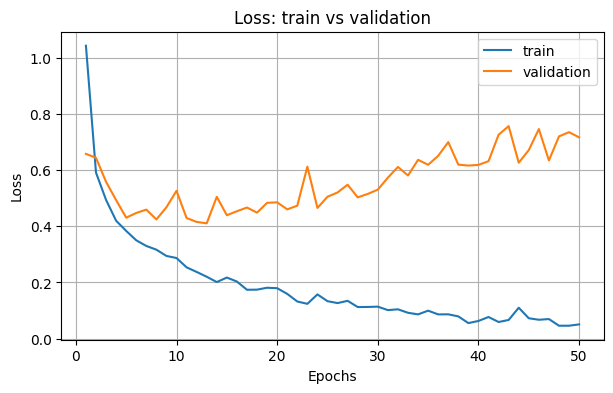

In [299]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

num_epochs = 50

d_train_1, d_val_1, _ = data.random_split(fmnist_dataset_train, [0.1, 0.1, 0.8])

train_loader_1 = data.DataLoader(d_train_1, batch_size=128, shuffle=True)
val_loader_1 = data.DataLoader(d_val_1, batch_size=128, shuffle=False)

loss_lst, loss_lst_val = train_nn(model=model,
                                  epochs=num_epochs, 
                                  train_data=train_loader_1, 
                                  optimizer=opt,
                                  train_data_val=val_loader_1)
test_model(test_loader, model)
plot_loss(loss_lst, loss_lst_val, num_epochs, ticks=False)

Обучал модель с многими слоями и большим количеством нейронов сперва на весь датасет, а потом на десятую часть.

Начиная с 9-10 эпох модель начинается переобучаться.

Если продолжить обучание до 50 эпох, получим accuracy на обучающем датасете почти 1.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [307]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=0.95),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=0.95),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.95),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)

Epoch [1/20], loss_mean=0.676, acc=0.773: 100%|██████████████████████████████████████| 399/399 [00:10<00:00, 36.43it/s]


 | Train_loss=0.676, Train_accuracy=0.773, Val_loss=0.510, Val_accuracy=0.825


Epoch [2/20], loss_mean=0.460, acc=0.839: 100%|██████████████████████████████████████| 399/399 [00:13<00:00, 30.36it/s]


 | Train_loss=0.460, Train_accuracy=0.839, Val_loss=0.438, Val_accuracy=0.850


Epoch [3/20], loss_mean=0.420, acc=0.855: 100%|██████████████████████████████████████| 399/399 [00:11<00:00, 35.98it/s]


 | Train_loss=0.420, Train_accuracy=0.855, Val_loss=0.419, Val_accuracy=0.852


Epoch [4/20], loss_mean=0.396, acc=0.861: 100%|██████████████████████████████████████| 399/399 [00:10<00:00, 37.39it/s]


 | Train_loss=0.396, Train_accuracy=0.861, Val_loss=0.405, Val_accuracy=0.862


Epoch [5/20], loss_mean=0.377, acc=0.866: 100%|██████████████████████████████████████| 399/399 [00:11<00:00, 34.90it/s]


 | Train_loss=0.377, Train_accuracy=0.866, Val_loss=0.391, Val_accuracy=0.866


Epoch [6/20], loss_mean=0.365, acc=0.871: 100%|██████████████████████████████████████| 399/399 [00:11<00:00, 34.58it/s]


 | Train_loss=0.365, Train_accuracy=0.871, Val_loss=0.382, Val_accuracy=0.869


Epoch [7/20], loss_mean=0.351, acc=0.875: 100%|██████████████████████████████████████| 399/399 [00:10<00:00, 36.65it/s]


 | Train_loss=0.351, Train_accuracy=0.875, Val_loss=0.372, Val_accuracy=0.870


Epoch [8/20], loss_mean=0.340, acc=0.880: 100%|██████████████████████████████████████| 399/399 [00:10<00:00, 37.56it/s]


 | Train_loss=0.340, Train_accuracy=0.880, Val_loss=0.379, Val_accuracy=0.870


Epoch [9/20], loss_mean=0.333, acc=0.882: 100%|██████████████████████████████████████| 399/399 [00:10<00:00, 36.96it/s]


 | Train_loss=0.333, Train_accuracy=0.882, Val_loss=0.354, Val_accuracy=0.877


Epoch [10/20], loss_mean=0.324, acc=0.883: 100%|█████████████████████████████████████| 399/399 [00:10<00:00, 36.34it/s]


 | Train_loss=0.324, Train_accuracy=0.883, Val_loss=0.360, Val_accuracy=0.872


Epoch [11/20], loss_mean=0.317, acc=0.887: 100%|█████████████████████████████████████| 399/399 [00:10<00:00, 36.78it/s]


 | Train_loss=0.317, Train_accuracy=0.887, Val_loss=0.342, Val_accuracy=0.883


Epoch [12/20], loss_mean=0.311, acc=0.888: 100%|█████████████████████████████████████| 399/399 [00:12<00:00, 31.77it/s]


 | Train_loss=0.311, Train_accuracy=0.888, Val_loss=0.353, Val_accuracy=0.878


Epoch [13/20], loss_mean=0.304, acc=0.891: 100%|█████████████████████████████████████| 399/399 [00:14<00:00, 26.88it/s]


 | Train_loss=0.304, Train_accuracy=0.891, Val_loss=0.338, Val_accuracy=0.881


Epoch [14/20], loss_mean=0.297, acc=0.892: 100%|█████████████████████████████████████| 399/399 [00:12<00:00, 32.28it/s]


 | Train_loss=0.297, Train_accuracy=0.892, Val_loss=0.341, Val_accuracy=0.882


Epoch [15/20], loss_mean=0.291, acc=0.895: 100%|█████████████████████████████████████| 399/399 [00:11<00:00, 36.14it/s]


 | Train_loss=0.291, Train_accuracy=0.895, Val_loss=0.345, Val_accuracy=0.878


Epoch [16/20], loss_mean=0.286, acc=0.895: 100%|█████████████████████████████████████| 399/399 [00:10<00:00, 36.83it/s]


 | Train_loss=0.286, Train_accuracy=0.895, Val_loss=0.333, Val_accuracy=0.883


Epoch [17/20], loss_mean=0.281, acc=0.898: 100%|█████████████████████████████████████| 399/399 [00:10<00:00, 37.24it/s]


 | Train_loss=0.281, Train_accuracy=0.898, Val_loss=0.323, Val_accuracy=0.885


Epoch [18/20], loss_mean=0.276, acc=0.899: 100%|█████████████████████████████████████| 399/399 [00:10<00:00, 36.88it/s]


 | Train_loss=0.276, Train_accuracy=0.899, Val_loss=0.328, Val_accuracy=0.885


Epoch [19/20], loss_mean=0.272, acc=0.902: 100%|█████████████████████████████████████| 399/399 [00:10<00:00, 36.57it/s]


 | Train_loss=0.272, Train_accuracy=0.902, Val_loss=0.336, Val_accuracy=0.881


Epoch [20/20], loss_mean=0.265, acc=0.903: 100%|█████████████████████████████████████| 399/399 [00:10<00:00, 37.70it/s]


 | Train_loss=0.265, Train_accuracy=0.903, Val_loss=0.344, Val_accuracy=0.881


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 24.15it/s]


Accuracy: 0.871


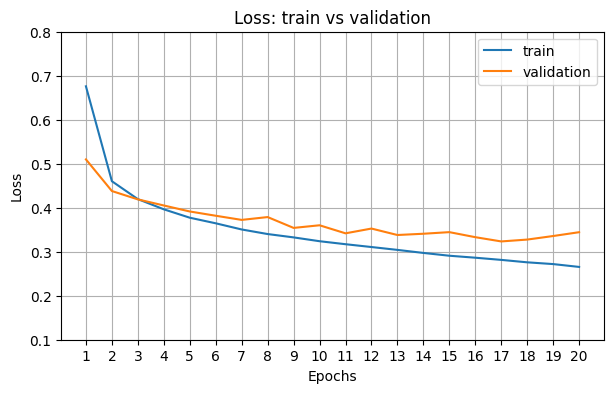

In [308]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()

num_epochs = 20

loss_lst, loss_lst_val = train_nn(model=model,
                                  epochs=num_epochs, 
                                  train_data=train_loader, 
                                  optimizer=opt,
                                  train_data_val=val_loader)

test_model(test_loader, model)

plot_loss(loss_lst, loss_lst_val, num_epochs)

### Conclusions:
_Write down small report with your conclusions and your ideas._

### Выводы

##### 1
Создал маленькую сеть из одного скрытого линейного слоя (128 нейронов). обучал 20 эпохов. После 12-13 эпох сеть начала немного переобучаться, но не сильно. На тесте показала точность 0.887 > 0.885.

##### 2
Чтобы модель сильно переобучалась, сперва добавил больше слоев и нейронов. Начала переобучаться уже с 7-ого эпоха. Потом решил сократить датасет и выбрал десятую часть, как обучающаяся часть. Обучал 20 эпох. А потом продолжил обучение до 50 эпохов. Точность на train почти приблизилась к 1. Результаты видны выше на графиках.

##### 3
Оставил ту же архитектуру, что во втором пункте, но добавил BatchNorm1d И Dropout слои. Точность не сильно пострадал, но переобучение снизил (видно на графике).
